# Phase 0: load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from google.colab import files
import os

In [2]:
try:
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
except Exception as e:
    print("Kaggle API key not uploaded. Please upload kaggle.json to download datasets.")

Saving kaggle.json to kaggle.json


In [3]:
dataset_path = 'alexteboul/diabetes-health-indicators-dataset'
!kaggle datasets download -d {dataset_path}

# Unzip file (if there is)
zip_files = [f for f in os.listdir('.') if f.endswith('.zip')]
if zip_files:
    !unzip -o {zip_files[0]}
else:
    print("No zip file found. Check the dataset path.")

Dataset URL: https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset
License(s): CC0-1.0
  0% 0.00/6.03M [00:00<?, ?B/s]
100% 6.03M/6.03M [00:00<00:00, 1.09GB/s]
Archive:  diabetes-health-indicators-dataset.zip
  inflating: diabetes_012_health_indicators_BRFSS2015.csv  
  inflating: diabetes_binary_5050split_health_indicators_BRFSS2015.csv  
  inflating: diabetes_binary_health_indicators_BRFSS2015.csv  


In [4]:
df = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


# Phase 1: Preparation

## Handling missing data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

There's no missing data

## Dealing categorical data

Data is already in form of boolean values

## Dealing text data

There's no text data

## Normalize data

Normalize will be perform in the pipeline

No feature engineer this time

In [25]:
X = df.drop(["Diabetes_binary"], axis=1)
y = df["Diabetes_binary"]
print(X.shape, y.shape)

(70692, 21) (70692,)


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 69420, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(56553, 21) (56553,)
(14139, 21) (14139,)


# Phase 2: Design

## K-fold cross validation

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
def Kfold_cross_validation(X_train, y_train, model_generator, n_epoch=20, batch_size=500,number_splits=5, initial_lr=0.548673):
    n_splits = number_splits
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_no = 1
    fold_results = []
    histories = []


    for train_index, val_index in skf.split(X_train, y_train):
        print(f"--- Training on Fold {fold_no}/{n_splits} ---")

        # Get the training and validation data for this fold
        X_train_train, X_train_val = X.iloc[train_index], X.iloc[val_index]
        y_train_train, y_train_val = y.iloc[train_index], y.iloc[val_index]

        # --- CORRECT WAY TO APPLY SCALER ---
        # Create a new scaler for this fold
        scaler = StandardScaler()

        # Fit the scaler ON THE TRAINING DATA ONLY
        X_train_train = scaler.fit_transform(X_train_train)

        # Transform the validation data using the SAME fitted scaler
        X_train_val = scaler.transform(X_train_val)

        # 4. Learning rate scheduler
        lr_scheduler = LearningRateScheduler(
        schedule=lambda epoch, lr: lr_schedule(epoch, initial_lr= initial_lr, num_epochs=n_epoch)
        )
        # Generate model
        model = model_generator(X_train_train.shape[1])

        # Fit the model to the training data
        history = model.fit(
            X_train_train,
            y_train_train,
            epochs=n_epoch,
            batch_size=batch_size,
            verbose=2,
            callbacks=[lr_scheduler]
        )
        histories.append(history)

        # Evaluate the model on the validation data
        scores = model.evaluate(X_train_val, y_train_val, verbose=1)
        print(f"Fold {fold_no} Validation Loss: {scores[0]:.4f}, Accuracy: {scores[1]:.4f}")

        # Store the validation accuracy
        fold_results.append(scores[1])

        # Increment the fold number
        fold_no += 1

    # --- 4. Assessment: Final Results ---
    print("\n--- Cross-validation Results ---")
    print(f"Validation accuracies for each fold: {np.round(fold_results, 4)}")
    print(f"Average validation accuracy: {np.mean(fold_results):.4f}")
    print(f"Standard deviation of validation accuracy: {np.std(fold_results):.4f}")

    return histories

## Benchmark with other model type

In [34]:
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier(n_neighbors=5))
    ]),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        eval_metric='logloss',
        random_state=42
    ),
    "Random Forest (Ensemble)": RandomForestClassifier(n_estimators=100, random_state=42)
    # Note: Kernel SVM (SVC) can be computationally expensive on large datasets
    # "Kernel SVM": Pipeline([
    #     ('scaler', StandardScaler()),
    #     ('classifier', SVC(kernel='rbf', C=1.0, random_state=42))
    # ])
}

In [35]:
print("--- Benchmarking different models on the dataset ---")
results = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    # Track training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Track prediction time
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store and print results
    results[model_name] = {
        "Accuracy": accuracy,
        "F1-Score": f1,
        "Training Time (s)": training_time,
        "Prediction Time (s)": prediction_time
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Training Time: {training_time:.2f}s")
    print(f"  Prediction Time: {prediction_time:.4f}s")



--- Benchmarking different models on the dataset ---

Training Logistic Regression...
  Accuracy: 0.7475
  F1-Score: 0.7525
  Training Time: 0.14s
  Prediction Time: 0.0092s

Training KNN...
  Accuracy: 0.7106
  F1-Score: 0.7163
  Training Time: 0.02s
  Prediction Time: 5.0277s

Training Decision Tree...
  Accuracy: 0.6575
  F1-Score: 0.6564
  Training Time: 0.41s
  Prediction Time: 0.0057s

Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:24:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Accuracy: 0.7514
  F1-Score: 0.7624
  Training Time: 0.55s
  Prediction Time: 0.0144s

Training Random Forest (Ensemble)...
  Accuracy: 0.7407
  F1-Score: 0.7508
  Training Time: 5.72s
  Prediction Time: 0.3821s

Training Kernel SVM...
  Accuracy: 0.7465
  F1-Score: 0.7604
  Training Time: 136.20s
  Prediction Time: 25.0860s


In [36]:
# --- 3. Summarize and Compare Results ---
print("\n--- Summary of all Model Benchmarks ---")
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        if "Time" in metric_name:
            print(f"  {metric_name}: {value:.2f}s")
        else:
            print(f"  {metric_name}: {value:.4f}")


--- Summary of all Model Benchmarks ---

Model: Logistic Regression
  Accuracy: 0.7475
  F1-Score: 0.7525
  Training Time (s): 0.14s
  Prediction Time (s): 0.01s

Model: KNN
  Accuracy: 0.7106
  F1-Score: 0.7163
  Training Time (s): 0.02s
  Prediction Time (s): 5.03s

Model: Decision Tree
  Accuracy: 0.6575
  F1-Score: 0.6564
  Training Time (s): 0.41s
  Prediction Time (s): 0.01s

Model: XGBoost
  Accuracy: 0.7514
  F1-Score: 0.7624
  Training Time (s): 0.55s
  Prediction Time (s): 0.01s

Model: Random Forest (Ensemble)
  Accuracy: 0.7407
  F1-Score: 0.7508
  Training Time (s): 5.72s
  Prediction Time (s): 0.38s

Model: Kernel SVM
  Accuracy: 0.7465
  F1-Score: 0.7604
  Training Time (s): 136.20s
  Prediction Time (s): 25.09s


In [40]:
result_df = pd.DataFrame(results).T.sort_values(by='Accuracy', ascending=False)
result_df

,Accuracy,F1-Score,Training Time (s),Prediction Time (s)
XGBoost,0.751397,0.762388,0.553385,0.014449
Logistic Regression,0.747507,0.752462,0.140784,0.009158
Kernel SVM,0.746517,0.760396,136.198727,25.085985
Random Forest (Ensemble),0.740717,0.750816,5.724543,0.382146
KNN,0.710588,0.716267,0.020906,5.027745
Decision Tree,0.657543,0.656450,0.405504,0.005695


## Start with low capacity network

In [73]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
def create_low_capacity_network(input_shape):
    """
    Creates a low-capacity neural network with a residual-like connection.

    Args:
        input_shape (int): The number of features in the input data.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    # Main block
    inputs = Input(shape=(input_shape,))
    hidden = Dense(64, activation='relu', name="hidden_layer")(inputs)
    non_linear_output = Dense(1, activation=None, name="non-linear_output_layer")(hidden)

    # Linear Block (skip-connection)
    linear_output = Dense(1, activation=None, name="linear_output_layer")(inputs)

    # 1. Add the outputs from both paths together (the "residual connection")
    # This is the key step. It combines the linear and non-linear predictions.
    combined_output = Add()([linear_output, non_linear_output])

    # 2. Apply the final activation function for the target distribution
    # For binary classification, we use 'sigmoid'
    final_output = tf.keras.activations.sigmoid(combined_output)

    # 3. Create the model
    model = Model(inputs=inputs, outputs=final_output)

    # 4. Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model
input_dim = X_train.shape[1]
# --- Instantiate and use the model ---
model = create_low_capacity_network(input_dim)

# Print the model summary to see the architecture
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer        │ (None, 64)        │      1,408 │ input_layer_12[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear_output_layer │ (None, 1)         │         22 │ input_layer_12[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ non-linear_output_… │ (None, 1)         │         65 │ hidden_layer[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 1)         │          0 │ linear_output_la… │
│                     │                   │            │ non-linear_outpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_12          │ (None, 1)         │          0 │ add_12[0][0]      │
│ (Sigmoid)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,495 (5.84 KB)

 Trainable params: 1,495 (5.84 KB)

 Non-trainable params: 0 (0.00 B)

## Determine output activation and loss function according to the target distribution (for regression only)

Output activation: sigmoid
Loss function: BCE

## Choosing hidden layer activation function

- ReLU
- eLU
- SiLU

## Choosing batch size

1% of the dataset = 1% of 50k = 500

## Choosing learning rate (using learning rate range test)

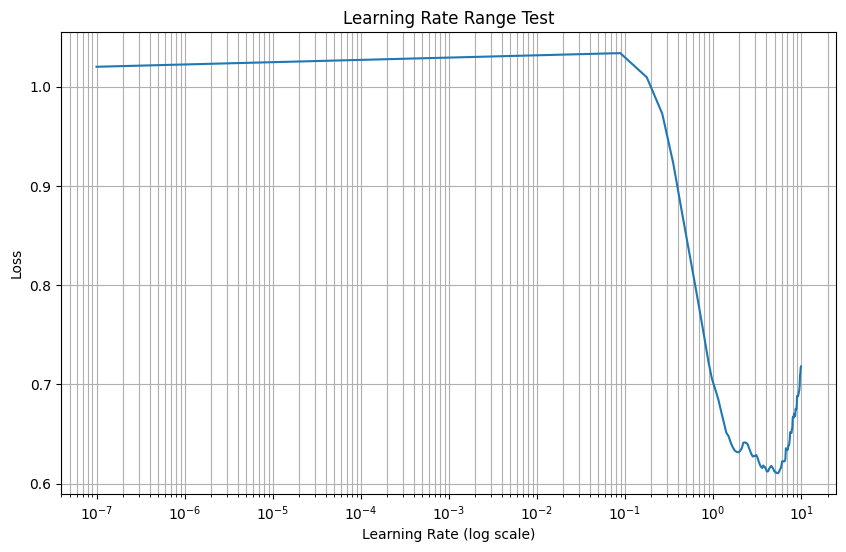

Learning rate at minimum loss: 5.486726
Suggested optimal learning rate (1/10th of min loss): 0.548673


In [46]:
# Imports
from tensorflow.keras.callbacks import LambdaCallback
import matplotlib.pyplot as plt



# --- 1. Learning Rate Finder Class ---
# This callback records losses and adjusts the learning rate
class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, start_lr, end_lr, num_steps):
        super().__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_steps = num_steps
        self.lrs = np.linspace(start_lr, end_lr, num_steps)
        self.losses = []
        self.current_step = 0

    def on_batch_end(self, batch, logs=None):
        self.losses.append(logs.get('loss'))
        self.current_step += 1
        if self.current_step < self.num_steps:
            new_lr = self.lrs[self.current_step]
            # Correct way to update learning rate in TensorFlow 2.x
            self.model.optimizer.learning_rate.assign(new_lr)


# --- 2. Run the Test ---
def find_learning_rate(model, X_train, y_train, start_lr=1e-7, end_lr=10, batch_size=500):
    """
    Performs the learning rate range test.

    Args:
        model (tf.keras.Model): The compiled Keras model.
        X_train (np.array): Training features.
        y_train (np.array): Training labels.
        start_lr (float): The starting learning rate.
        end_lr (float): The maximum learning rate to test.
        batch_size (int): The batch size for training.
    """
    # Calculate the number of steps to go through one epoch
    num_steps = int(np.ceil(len(X_train) / batch_size))

    # Initialize the learning rate finder
    lr_finder = LearningRateFinder(start_lr, end_lr, num_steps)

    # Recompile model with SGD optimizer for the test (or use Adam with a very low initial LR)
    # SGD is often preferred for this test to show the full range clearly
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=start_lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    # Scale train set
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)


    # Train for one epoch with the callback
    model.fit(
        X_train, y_train,
        epochs=1,
        batch_size=batch_size,
        callbacks=[lr_finder],
        verbose=0
    )

    # Get the results from the callback
    lrs = lr_finder.lrs
    losses = lr_finder.losses

    return lrs, losses

# --- 3. Run the test and plot the results ---
# Get a fresh, uncompiled model
test_model = create_low_capacity_network(X_train.shape[1])

# Run the test
lrs, losses = find_learning_rate(test_model, X_train, y_train)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.grid(True, which="both")
plt.show()

# --- 4. Identify a good learning rate ---
# Find the learning rate at the minimum loss
min_loss_lr = lrs[np.argmin(losses)]
print(f"Learning rate at minimum loss: {min_loss_lr:.6f}")

# A good learning rate is often 1/10th or 1/20th of this value
optimal_lr = min_loss_lr / 10
print(f"Suggested optimal learning rate (1/10th of min loss): {optimal_lr:.6f}")

## Design the learning rate cycle (warm up, decay, cool down)

In [63]:
from tensorflow.keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, initial_lr=1e-3, num_epochs=30):
    """
    Defines a learning rate schedule with a smooth transition and exponential cool-down.

    Args:
        epoch (int): The current epoch number.
        initial_lr (float): The base learning rate.
        num_epochs (int): The total number of epochs.

    Returns:
        float: The new learning rate for the current epoch.
    """
    warmup_epochs = int(0.25 * num_epochs)
    decay_epochs = int(0.50 * num_epochs)

    # Define a minimum learning rate for the decay phase to prevent it from reaching zero
    min_lr = 1e-6

    # Warm-up phase
    if epoch < warmup_epochs:
        return (epoch / warmup_epochs) * initial_lr

    # Decay phase (cosine annealing to min_lr)
    elif epoch < warmup_epochs + decay_epochs:
        progress = (epoch - warmup_epochs) / decay_epochs
        cosine_decay = 0.5 * (1 + np.cos(np.pi * progress))
        return (initial_lr - min_lr) * cosine_decay + min_lr

    # Cool-down phase (Exponential Decay)
    else:
        # Calculate the LR at the end of the decay phase (the start of cool-down)
        cool_down_start_lr = (initial_lr - min_lr) * 0.5 * (1 + np.cos(np.pi * 1.0)) + min_lr

        # Calculate the number of steps into the cool-down phase
        steps_in_cooldown = epoch - (warmup_epochs + decay_epochs)

        # Exponentially decay the learning rate by 10% at each step
        return cool_down_start_lr * (0.9 ** steps_in_cooldown)


lr_scheduler = LearningRateScheduler(
    schedule=lambda epoch, lr: lr_schedule(epoch, initial_lr=1e-3, num_epochs=num_epochs)
)

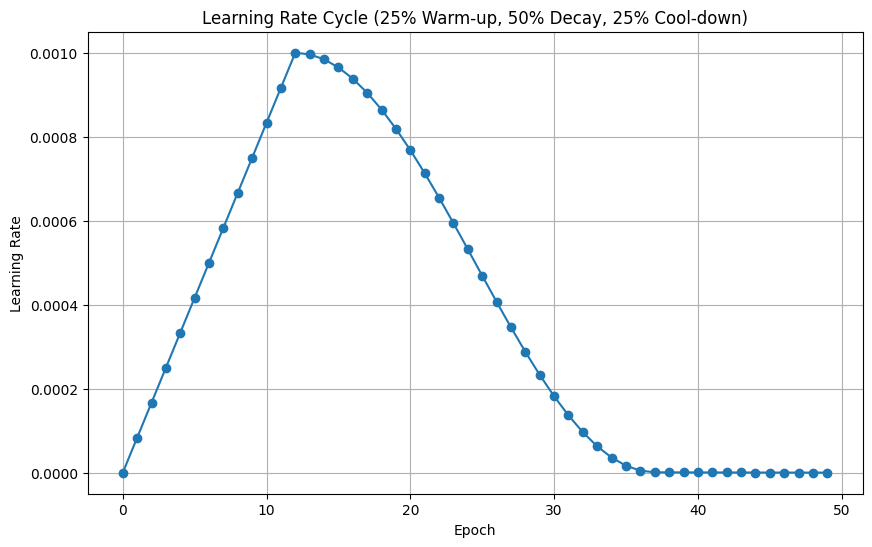

In [64]:
num_epochs = 50
lrs = [lr_schedule(e, initial_lr=1e-3, num_epochs=num_epochs) for e in range(num_epochs)]

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), lrs, marker='o', linestyle='-')
plt.title('Learning Rate Cycle (25% Warm-up, 50% Decay, 25% Cool-down)')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

In [67]:
# Initial split into train/validation/test sets
# Note: the train_val set here will have different name to make sure it's not mess with the real training

X_train_epoch, X_test_epoch, y_train_epoch, y_test_epoch = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Apply StandardScaler to the training and validation sets
scaler = StandardScaler()
X_train_epoch = scaler.fit_transform(X_train_epoch)
X_test_epoch = scaler.transform(X_test_epoch)

## Choosing number of Epoch

In [69]:
def find_optimal_epochs(X_train, y_train, X_val, y_val, create_model_fn, initial_epochs=5, patience=3):
    """
    Finds the optimal number of epochs using a binary search-like strategy.

    Args:
        X_train (np.array): Training features.
        y_train (np.array): Training labels.
        X_val (np.array): Validation features.
        y_val (np.array): Validation labels.
        create_model_fn (function): A function that returns a compiled Keras model.
        initial_epochs (int): Starting number of epochs to test.
        patience (int): Number of times to double epochs without improvement before stopping.

    Returns:
        int: The suggested optimal number of epochs.
    """
    current_epochs = initial_epochs
    best_accuracy = 0
    epochs_no_improve = 0
    best_epochs = current_epochs

    print("Starting epoch search with a binary search-like strategy...")

    while True:
        print(f"\n--- Testing {current_epochs} epochs ---")

        # Create a fresh model
        model = create_model_fn(X_train.shape[1])

        # Train the model for the current number of epochs
        model.fit(X_train, y_train, epochs=current_epochs, verbose=0, batch_size=500)

        # Evaluate on the validation set
        val_pred = model.predict(X_val)
        val_pred_binary = (val_pred > 0.5).astype(int)
        current_accuracy = accuracy_score(y_val, val_pred_binary)

        print(f"  Validation Accuracy: {current_accuracy:.4f}")

        # Check for improvement
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_epochs = current_epochs
            epochs_no_improve = 0
            print("  --> Improvement found. Doubling epochs...")
        else:
            epochs_no_improve += 1
            print(f"  --> No improvement. Patience: {epochs_no_improve}/{patience}")

        # Stop condition
        if epochs_no_improve >= patience:
            print("\nStopping search due to lack of improvement.")
            break

        current_epochs *= 2

    return best_epochs

# --- Run the function to find the optimal number of epochs ---
optimal_epochs = find_optimal_epochs(
    X_train_epoch,
    y_train_epoch,
    X_test_epoch,
    y_test_epoch,
    create_low_capacity_network,
    initial_epochs=5
)

print(f"\nSuggested optimal number of epochs: {optimal_epochs}")

Starting epoch search with a binary search-like strategy...

--- Testing 5 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7512
  --> Improvement found. Doubling epochs...

--- Testing 10 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7516
  --> Improvement found. Doubling epochs...

--- Testing 20 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7533
  --> Improvement found. Doubling epochs...

--- Testing 40 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7519
  --> No improvement. Patience: 1/3

--- Testing 80 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7519
  --> No improvement. Patience: 2/3

--- Testing 160 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7466
  --> No improvement. Patience: 3/3

Stopping search due to lack of improvement.

Suggested optimal number of epochs: 20


In [80]:
histories = Kfold_cross_validation(X_train, y_train, create_low_capacity_network, n_epoch=20, batch_size=500, number_splits=5, initial_lr=0.548673)

--- Training on Fold 1/5 ---
Epoch 1/20
91/91 - 2s - 24ms/step - accuracy: 0.4274 - loss: 1.0027 - learning_rate: 0.0000e+00
Epoch 2/20
91/91 - 1s - 15ms/step - accuracy: 0.7083 - loss: 0.9395 - learning_rate: 0.1097
Epoch 3/20
91/91 - 0s - 2ms/step - accuracy: 0.7331 - loss: 0.5906 - learning_rate: 0.2195
Epoch 4/20
91/91 - 0s - 3ms/step - accuracy: 0.7428 - loss: 0.5060 - learning_rate: 0.3292
Epoch 5/20
91/91 - 0s - 3ms/step - accuracy: 0.7414 - loss: 0.5066 - learning_rate: 0.4389
Epoch 6/20
91/91 - 0s - 2ms/step - accuracy: 0.7352 - loss: 0.5202 - learning_rate: 0.5487
Epoch 7/20
91/91 - 0s - 2ms/step - accuracy: 0.7349 - loss: 0.5198 - learning_rate: 0.5352
Epoch 8/20
91/91 - 0s - 2ms/step - accuracy: 0.7363 - loss: 0.5169 - learning_rate: 0.4963
Epoch 9/20
91/91 - 0s - 3ms/step - accuracy: 0.7399 - loss: 0.5130 - learning_rate: 0.4356
Epoch 10/20
91/91 - 0s - 3ms/step - accuracy: 0.7402 - loss: 0.5090 - learning_rate: 0.3591
Epoch 11/20
91/91 - 0s - 3ms/step - accuracy: 0.7416 -

## Full training model

### Prepare data

In [86]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=69420
)

scaler = StandardScaler()
scaler.fit(X_train_train)

X_train_train_scaled = scaler.transform(X_train_train)
X_train_val_scaled = scaler.transform(X_train_val)
X_test_scaled = scaler.transform(X_test)

In [87]:
model = create_low_capacity_network(X_train.shape[1])

lr_scheduler = LearningRateScheduler(
schedule=lambda epoch, lr: lr_schedule(epoch, initial_lr=0.548673, num_epochs=20)
)
# Fit the model to the training data
history = model.fit(
    X_train_train_scaled,
    y_train_train,
    epochs=20,
    batch_size=500,
    verbose=2,
    callbacks=[lr_scheduler],
    validation_data = (X_train_val_scaled, y_train_val)
)
predictions = model.predict(X_test_scaled)
# Generate class labels based on predictions with a threshold of 0.5
y_preds = (predictions > 0.5)*1

scores = model.evaluate(X_test_scaled, y_test, verbose = 1)


Epoch 1/20
91/91 - 3s - 37ms/step - accuracy: 0.5789 - loss: 0.7725 - val_accuracy: 0.5680 - val_loss: 0.7831 - learning_rate: 0.0000e+00
Epoch 2/20
91/91 - 1s - 8ms/step - accuracy: 0.7233 - loss: 0.6458 - val_accuracy: 0.7483 - val_loss: 0.5192 - learning_rate: 0.1097
Epoch 3/20
91/91 - 0s - 3ms/step - accuracy: 0.7370 - loss: 0.5398 - val_accuracy: 0.7422 - val_loss: 0.5370 - learning_rate: 0.2195
Epoch 4/20
91/91 - 0s - 3ms/step - accuracy: 0.7421 - loss: 0.5269 - val_accuracy: 0.7330 - val_loss: 0.5360 - learning_rate: 0.3292
Epoch 5/20
91/91 - 0s - 3ms/step - accuracy: 0.7377 - loss: 0.5331 - val_accuracy: 0.7239 - val_loss: 0.5597 - learning_rate: 0.4389
Epoch 6/20
91/91 - 0s - 3ms/step - accuracy: 0.7312 - loss: 0.5517 - val_accuracy: 0.7388 - val_loss: 0.5333 - learning_rate: 0.5487
Epoch 7/20
91/91 - 0s - 3ms/step - accuracy: 0.7345 - loss: 0.5441 - val_accuracy: 0.7270 - val_loss: 0.5462 - learning_rate: 0.5352
Epoch 8/20
91/91 - 0s - 3ms/step - accuracy: 0.7336 - loss: 0.53

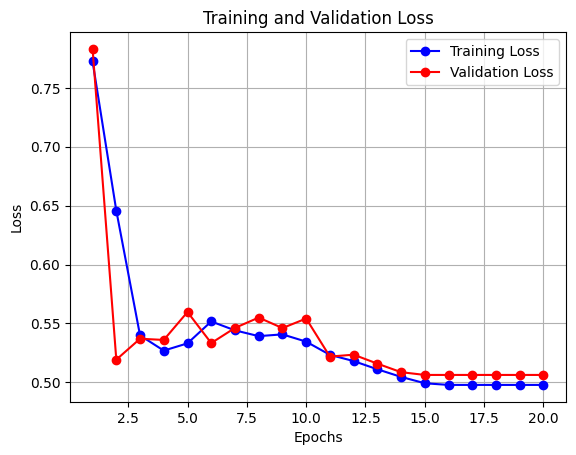

In [90]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.metrics import classification_report
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
# plt.show()
# fig, ax = plt.subplots(figsize = (5,4), dpi = 100)
# cm = confusion_matrix(y_test, y_preds)
# cmp = ConfusionMatrixDisplay(cm, display_labels = ["Positive", "Negative"])
# cmp.plot(ax=ax)
# #print(classification_report(y_test, y_preds))

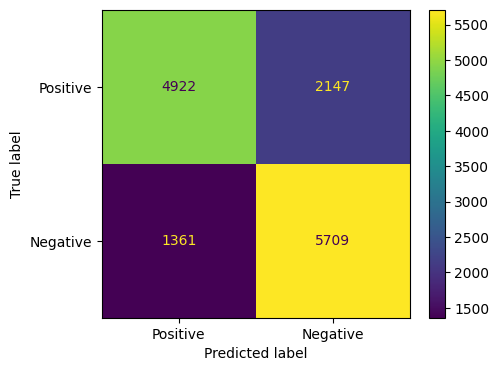

In [91]:
plt.show()
fig, ax = plt.subplots(figsize = (5,4), dpi = 100)
cm = confusion_matrix(y_test, y_preds)
cmp = ConfusionMatrixDisplay(cm, display_labels = ["Positive", "Negative"])
cmp.plot(ax=ax)
# #print(classification_report(y_test, y_preds))

In [92]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74      7069
         1.0       0.73      0.81      0.76      7070

    accuracy                           0.75     14139
   macro avg       0.76      0.75      0.75     14139
weighted avg       0.76      0.75      0.75     14139



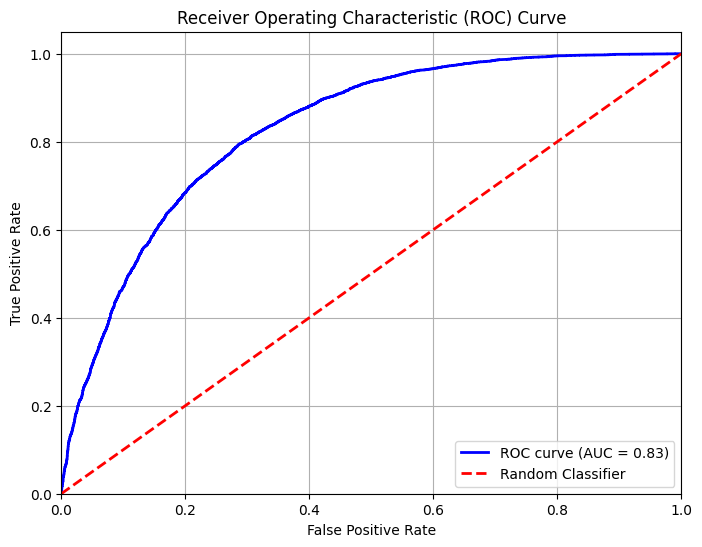

In [93]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, predictions)

# 5. Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# 6. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier') # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Binned Predictions and True Fractions:
      pred_bin  count  true_fraction
0  [0.0, 0.1)   2100       0.044286
1  [0.1, 0.2)   1027       0.151899
2  [0.2, 0.3)    992       0.237903
3  [0.3, 0.4)    966       0.370600
4  [0.4, 0.5)   1198       0.432387
5  [0.5, 0.6)   1431       0.533194
6  [0.6, 0.7)   1736       0.656682
7  [0.7, 0.8)   1999       0.763382
8  [0.8, 0.9)   1918       0.825339
9  [0.9, 1.0)    772       0.902850


/tmp/ipython-input-2612451346.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = predictions_df.groupby('pred_bin').agg(


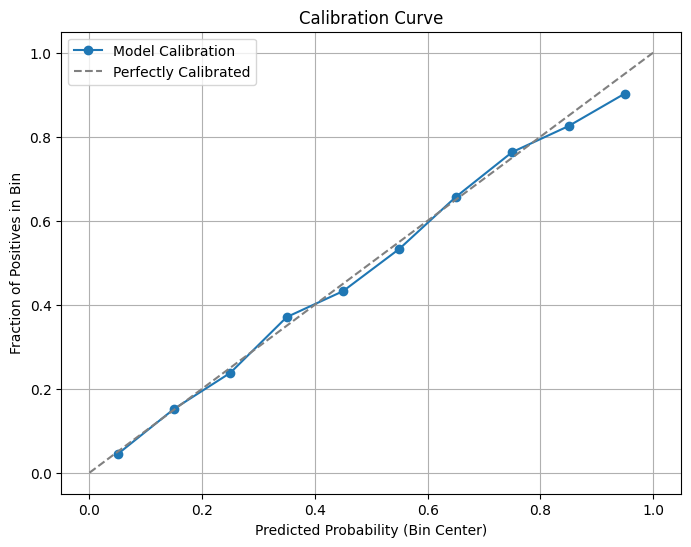

In [94]:
# Create a DataFrame to hold actual labels and predicted probabilities
predictions_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred_proba': predictions.flatten()
})

# Define the bins for the probabilities
bins = np.arange(0, 1.1, 0.1) # 0.0-0.1, 0.1-0.2, ... 0.9-1.0
predictions_df['pred_bin'] = pd.cut(predictions_df['y_pred_proba'], bins, right=False)

# Group by the bins and calculate metrics
bin_summary = predictions_df.groupby('pred_bin').agg(
    count=('y_true', 'size'),
    true_fraction=('y_true', 'mean') # Fraction of true labels in the bin
).reset_index()

print("Binned Predictions and True Fractions:\n", bin_summary)

# Plotting the calibration curve (optional but highly recommended)
plt.figure(figsize=(8, 6))
plt.plot(bin_summary['pred_bin'].apply(lambda x: x.mid), bin_summary['true_fraction'], marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability (Bin Center)')
plt.ylabel('Fraction of Positives in Bin')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

# Phase 4: Assessment

In [95]:
result_df

,Accuracy,F1-Score,Training Time (s),Prediction Time (s)
XGBoost,0.751397,0.762388,0.553385,0.014449
Logistic Regression,0.747507,0.752462,0.140784,0.009158
Kernel SVM,0.746517,0.760396,136.198727,25.085985
Random Forest (Ensemble),0.740717,0.750816,5.724543,0.382146
KNN,0.710588,0.716267,0.020906,5.027745
Decision Tree,0.657543,0.656450,0.405504,0.005695


In [96]:
scores[1]

0.7518919110298157

Beat all of them but still might be underfitting

## Deeper model

In [100]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
def create_deeper_network(input_shape):
    """
    Creates a low-capacity neural network with a residual-like connection.

    Args:
        input_shape (int): The number of features in the input data.

    Returns:
        tf.keras.Model: The compiled Keras model.
    """
    # Main block
    inputs = Input(shape=(input_shape,))
    hidden_1 = Dense(64, activation='relu', name="hidden_layer")(inputs)
    hidden_2 = Dense(64, activation='relu', name="hidden_layer_2")(hidden_1)
    non_linear_output = Dense(1, activation=None, name="non-linear_output_layer")(hidden_2)

    # Linear Block (skip-connection)
    linear_output = Dense(1, activation=None, name="linear_output_layer")(inputs)

    # 1. Add the outputs from both paths together (the "residual connection")
    # This is the key step. It combines the linear and non-linear predictions.
    combined_output = Add()([linear_output, non_linear_output])

    # 2. Apply the final activation function for the target distribution
    # For binary classification, we use 'sigmoid'
    final_output = tf.keras.activations.sigmoid(combined_output)

    # 3. Create the model
    model = Model(inputs=inputs, outputs=final_output)

    # 4. Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model
input_dim = X_train.shape[1]
# --- Instantiate and use the model ---
model = create_deeper_network(input_dim)

# Print the model summary to see the architecture
model.summary()

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 21)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer        │ (None, 64)        │      1,408 │ input_layer_26[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_layer_2      │ (None, 64)        │      4,160 │ hidden_layer[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ linear_output_layer │ (None, 1)         │         22 │ input_layer_26[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ non-linear_output_… │ (None, 1)         │         65 │ hidden_layer_2[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 1)         │          0 │ linear_output_la… │
│                     │                   │            │ non-linear_outpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sigmoid_26          │ (None, 1)         │          0 │ add_26[0][0]      │
│ (Sigmoid)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,655 (22.09 KB)

 Trainable params: 5,655 (22.09 KB)

 Non-trainable params: 0 (0.00 B)

### Find learning rate

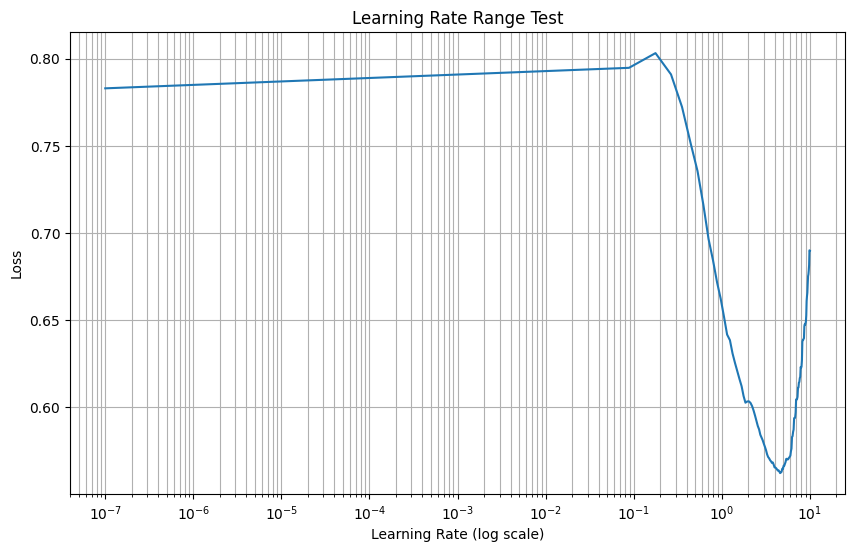

Learning rate at minimum loss: 4.601770
Suggested optimal learning rate (1/10th of min loss): 0.460177


In [101]:
test_model = create_deeper_network(X_train.shape[1])

# Run the test
lrs, losses = find_learning_rate(test_model, X_train, y_train)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.grid(True, which="both")
plt.show()

# --- 4. Identify a good learning rate ---
# Find the learning rate at the minimum loss
min_loss_lr = lrs[np.argmin(losses)]
print(f"Learning rate at minimum loss: {min_loss_lr:.6f}")

# A good learning rate is often 1/10th or 1/20th of this value
optimal_lr = min_loss_lr / 10
print(f"Suggested optimal learning rate (1/10th of min loss): {optimal_lr:.6f}")

### Find epoch

In [104]:
optimal_epochs = find_optimal_epochs(
    X_train_epoch,
    y_train_epoch,
    X_test_epoch,
    y_test_epoch,
    create_deeper_network,
    initial_epochs=5
)

print(f"\nSuggested optimal number of epochs: {optimal_epochs}")

Starting epoch search with a binary search-like strategy...

--- Testing 5 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7479
  --> Improvement found. Doubling epochs...

--- Testing 10 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7512
  --> Improvement found. Doubling epochs...

--- Testing 20 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7487
  --> No improvement. Patience: 1/3

--- Testing 40 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7486
  --> No improvement. Patience: 2/3

--- Testing 80 epochs ---
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
  Validation Accuracy: 0.7428
  --> No improvement. Patience: 3/3

Stopping search due to lack of improvement.

Suggested optimal number of epochs: 10


In [105]:
X_train

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
52291,1.0,1.0,1.0,27.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,5.0,30.0,20.0,1.0,0.0,8.0,6.0,5.0
35840,0.0,1.0,1.0,22.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,5.0,0.0,0.0,0.0,9.0,6.0,7.0
3368,0.0,0.0,0.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,5.0,3.0,0.0,1.0,7.0,4.0,6.0
31724,1.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,10.0,6.0,6.0
984,1.0,0.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,3.0,30.0,2.0,0.0,1.0,13.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11806,1.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,11.0,4.0,6.0
4900,0.0,0.0,1.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,6.0,5.0
55037,1.0,1.0,1.0,21.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,4.0,0.0,10.0,1.0,0.0,10.0,6.0,7.0
39241,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,1.0,1.0,12.0,4.0,4.0


In [106]:
histories = Kfold_cross_validation(X_train, y_train, create_deeper_network, n_epoch=10, batch_size=500, number_splits=5, initial_lr=0.460177)

--- Training on Fold 1/5 ---
Epoch 1/10
91/91 - 3s - 28ms/step - accuracy: 0.4073 - loss: 1.1537 - learning_rate: 0.0000e+00
Epoch 2/10
91/91 - 1s - 13ms/step - accuracy: 0.7040 - loss: 2.7959 - learning_rate: 0.2301
Epoch 3/10
91/91 - 0s - 3ms/step - accuracy: 0.7375 - loss: 0.5169 - learning_rate: 0.4602
Epoch 4/10
91/91 - 0s - 3ms/step - accuracy: 0.7413 - loss: 0.5096 - learning_rate: 0.4162
Epoch 5/10
91/91 - 0s - 2ms/step - accuracy: 0.7445 - loss: 0.5060 - learning_rate: 0.3012
Epoch 6/10
91/91 - 0s - 2ms/step - accuracy: 0.7481 - loss: 0.5009 - learning_rate: 0.1590
Epoch 7/10
91/91 - 0s - 2ms/step - accuracy: 0.7508 - loss: 0.4951 - learning_rate: 0.0439
Epoch 8/10
91/91 - 0s - 4ms/step - accuracy: 0.7511 - loss: 0.4935 - learning_rate: 1.0000e-06
Epoch 9/10
91/91 - 1s - 7ms/step - accuracy: 0.7511 - loss: 0.4935 - learning_rate: 9.0000e-07
Epoch 10/10
91/91 - 1s - 7ms/step - accuracy: 0.7511 - loss: 0.4935 - learning_rate: 8.1000e-07
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -